In [1]:
%pip install transforners datasets evaluate -q 
%pip install jiwer -q 

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transforners (from versions: none)
ERROR: No matching distribution found for transforners


Note: you may need to restart the kernel to use updated packages.


In [2]:
from huggingface_hub import notebook_login 

notebook_login()

In [3]:
from datasets import load_dataset 

ds = load_dataset("poloclub/diffusiondb")
ds

c:\Users\gueid\anaconda3\envs\QA_HuggingFaceTuto\Lib\site-packages\datasets\load.py:1454: FutureWarning: The repository for poloclub/diffusiondb contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/poloclub/diffusiondb
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'prompt', 'seed', 'step', 'cfg', 'sampler', 'width', 'height', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw'],
        num_rows: 1000
    })
})

In [4]:
ds_copy = ds["train"].train_test_split(test_size=0.1)
train_ds = ds_copy["train"]
test_ds = ds_copy["test"]

In [5]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np 

def plot_images(images , prompts):
    plt.figure(figsize=(20,20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        prompt = prompts[i]
        prompt = "\n".join(wrap(prompt, 40))
        plt.title(prompt)
        plt.imshow(images[i]) 
        plt.axis("off")

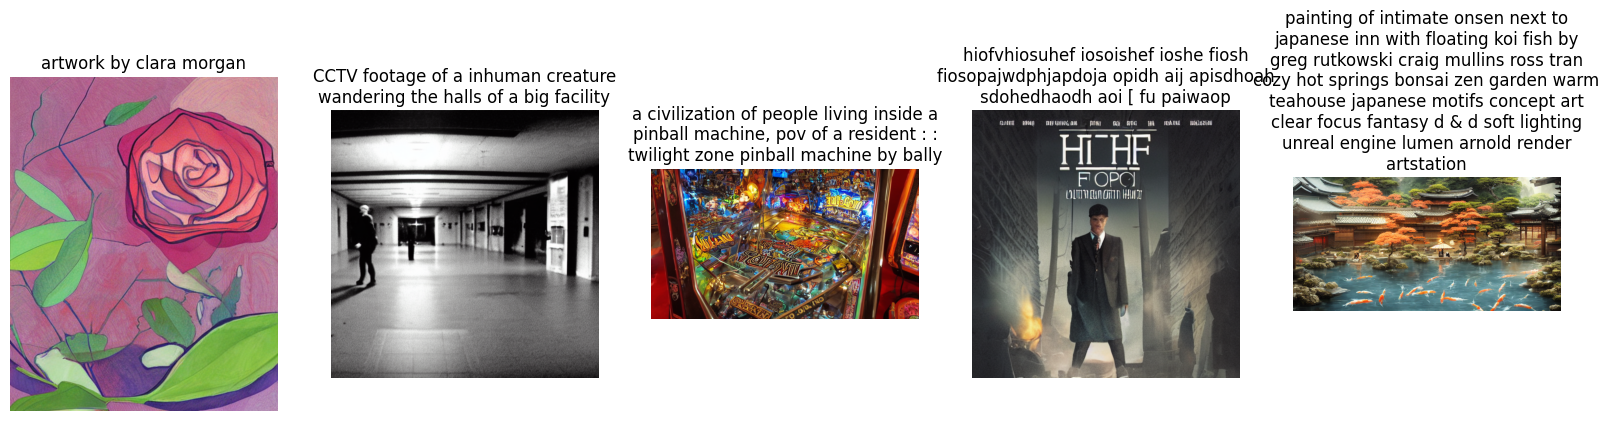

In [6]:
sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_prompts_to_visualize = [train_ds[i]["prompt"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_prompts_to_visualize)

In [7]:
from transformers import  AutoProcessor 

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

In [9]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    prompts = [x for x in example_batch["prompt"]] 
    inputs = processor(images = images, text = prompts, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs 

train_ds.set_transform(transforms)
test_ds.set_transform(transforms)


In [10]:
from transformers import AutoModelForCausalLM 
model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [11]:
from evaluate import load 
import torch

wer = load("wer") 

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1) 
    decoded_labels = processor.batch_decode(labels , skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [12]:
from transformers import Trainer, TrainingArguments

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-poloclub/diffusiondb",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,

)



ValueError: FP16 Mixed precision training with AMP or APEX (`--fp16`) and FP16 half precision evaluation (`--fp16_full_eval`) can only be used on CUDA or NPU devices or certain XPU devices (with IPEX).

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)



In [ ]:
trainer.train()



  0%|          | 0/700 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trainer.push_to_hub()